# Coding Exercise 9

### Task 9.1 

In [1]:
import os
import geopandas as gpd
import pandas as pd
import folium
os.chdir('/Users/[editted]/Dropbox/work/compsoc/dataset')
os.listdir()

boston_zip_gdf = gpd.read_file('ZIP_Codes.geojson')
print(boston_zip_gdf.columns)

Index(['OBJECTID', 'ZIP5', 'ShapeSTArea', 'ShapeSTLength', 'geometry'], dtype='object')


In [2]:
crime_df = pd.read_csv('/Users/[editted]/Dropbox/work/compsoc/dataset/crime_cleaned.csv')
crime_df19=crime_df[crime_df.YEAR==2019]
crime_gdf = gpd.GeoDataFrame(crime_df19, geometry=gpd.points_from_xy(crime_df19['Long'], crime_df19['Lat']))
crime_gdf.set_crs(epsg=4326, inplace=True) 
crime_gdf = crime_gdf[crime_gdf['Long'] < 0].reset_index()

crime_gdf = gpd.GeoDataFrame(crime_df19, geometry=gpd.points_from_xy(crime_df19['Long'], crime_df19['Lat']), crs=4326)
crime_with_zip_gdf = gpd.sjoin(crime_gdf, boston_zip_gdf, predicate="within", how='left')
crime_with_zip_gdf.set_crs(epsg=4326, inplace=True)


crime_count_by_zip=crime_with_zip_gdf.groupby(['OBJECTID']).agg({'INCIDENT_NUMBER': 'count'}).reset_index().sort_values(by=['OBJECTID'])
crime_count_by_zip['OBJECTID'] = crime_count_by_zip['OBJECTID'].astype(int)
crime_count_gdf = boston_zip_gdf[['OBJECTID', 'geometry']].merge(crime_count_by_zip, how='inner', on='OBJECTID')

/var/folders/1b/s20n0f295fn5s0f986q3fppc0000gn/T/ipykernel_5967/4218512209.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_df = pd.read_csv('/Users/gohtk/Dropbox/work/compsoc/dataset/crime_cleaned.csv')


In [6]:
clon, clat = crime_count_gdf['geometry'].centroid.x.mean(), crime_count_gdf['geometry'].centroid.y.mean()
m = folium.Map(location=(clat, clon), zoom_start=11, width=800, height=400, tiles="Cartodb Positron")
folium.Choropleth(
    geo_data=crime_count_gdf,
    name="choropleth",
    data=crime_count_gdf,
    columns= ["OBJECTID","INCIDENT_NUMBER"],
    key_on="feature.properties.OBJECTID", # key from geojson file. replace the last argument (OBJECTID) to change identifier.
    fill_color='OrRd', #‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Annual crime count by Zip Codes, Boston, 2019").add_to(m)

display(m)

/var/folders/1b/s20n0f295fn5s0f986q3fppc0000gn/T/ipykernel_5967/3522938788.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clon, clat = crime_count_gdf['geometry'].centroid.x.mean(), crime_count_gdf['geometry'].centroid.y.mean()
/var/folders/1b/s20n0f295fn5s0f986q3fppc0000gn/T/ipykernel_5967/3522938788.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clon, clat = crime_count_gdf['geometry'].centroid.x.mean(), crime_count_gdf['geometry'].centroid.y.mean()


#### Bonus Task 1

In [24]:
import plotly.express as px

life_exp=pd.read_csv('life-expectancy.csv').rename(columns={'Life expectancy': 'Life_expectancy'}).dropna()
birthrate=pd.read_csv('crude-birth-rate.csv').rename(columns={'Birth rate - sex: all - age: all - variant: estimates': 'Birth_rate'}).dropna()
pop=pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_4578059.csv', skiprows=3).drop(['Unnamed: 66'], axis=1).dropna()

pop_long=pd.melt(pop,id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],var_name='Year', value_name='population')
pop_long=pop_long.rename(columns={"Country Name": 'Entity', 'Country Code': 'Code'})
pop_long.Year=pop_long['Year'].astype(int)

CountryCode=pd.read_csv('https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv',sep=',')
CountryCode=CountryCode[['Continent_Name', 'Three_Letter_Country_Code']].rename(columns={'Continent_Name': 'Continent', 'Three_Letter_Country_Code': 'Code'})
# ContryCode to identify the continental groups among countries

lb_merged=life_exp.merge(birthrate, how='left', on=['Entity', 'Code', 'Year'])
lbp_merged=lb_merged.merge(pop_long, how='left', on=['Entity', 'Code', 'Year']).rename(columns={'Entity': 'Country'})
lbp_c_merged=lbp_merged.merge(CountryCode, how='left', on='Code')

cleanlist=['Year', 'Life_expectancy', 'Birth_rate', 'population']
lbp_c_cleaned=lbp_c_merged.drop_duplicates(subset=cleanlist).dropna(subset=cleanlist)
lbp_c_cleaned

Country Code  Year  Life_expectancy  Birth_rate     Indicator Name  \
10     Afghanistan  AFG  1960           32.446   50.340000  Population, total   
11     Afghanistan  AFG  1961           32.962   50.443001  Population, total   
12     Afghanistan  AFG  1962           33.471   50.570000  Population, total   
13     Afghanistan  AFG  1963           33.971   50.702999  Population, total   
14     Afghanistan  AFG  1964           34.463   50.831001  Population, total   
...            ...  ...   ...              ...         ...                ...   
18972     Zimbabwe  ZWE  2015           59.534   33.959999  Population, total   
18973     Zimbabwe  ZWE  2016           60.294   33.171001  Population, total   
18974     Zimbabwe  ZWE  2017           60.812   32.515999  Population, total   
18975     Zimbabwe  ZWE  2018           61.195   32.074001  Population, total   
18976     Zimbabwe  ZWE  2019           61.490   31.518000  Population, total   

      Indicator Code  population Continent  
10       SP.POP.TOTL   8996967.0      Asia  
11       SP.POP.TOTL   9169406.0      Asia  
12       SP.POP.TOTL   9351442.0      Asia  
13       SP.POP.TOTL   9543200.0      Asia  
14       SP.POP.TOTL   9744772.0      Asia  
...              ...         ...       ...  
18972    SP.POP.TOTL  13814642.0    Africa  
18973    SP.POP.TOTL  14030338.0    Africa  
18974    SP.POP.TOTL  14236599.0    Africa  
18975    SP.POP.TOTL  14438812.0    Africa  
18976    SP.POP.TOTL  14645473.0    Africa  

[10980 rows x 9 columns]

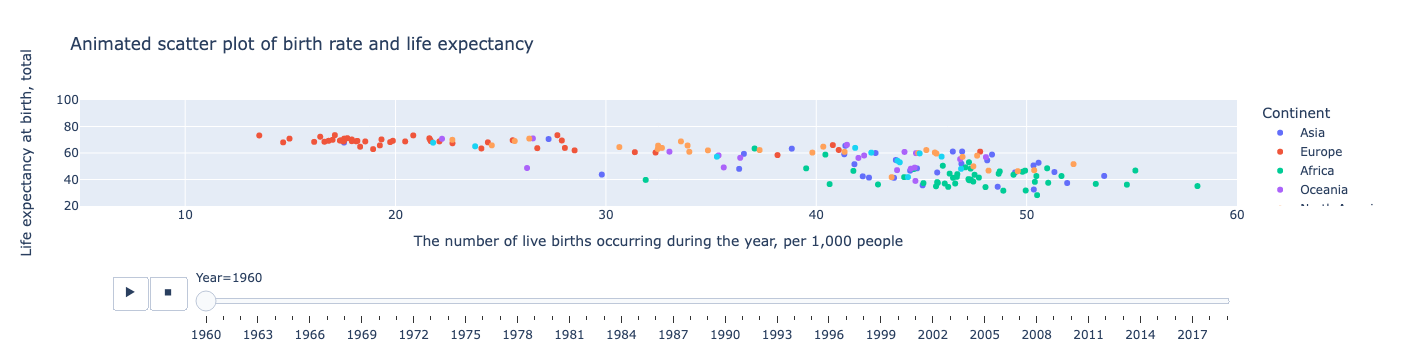

In [26]:
px.scatter(lbp_c_cleaned, 
           x="Birth_rate", 
           y="Life_expectancy", 
           animation_frame="Year",
           animation_group="Country", 
           color="Continent", 
           hover_name="Continent",
           range_x=[5,60], 
           range_y=[20,100],
           labels ={"Birth_rate": 'The number of live births occurring during the year, per 1,000 people',
                    'Life_expectancy': 'Life expectancy at birth, total', }, 
           title='Animated scatter plot of birth rate and life expectancy')

#### Bonus Task 2

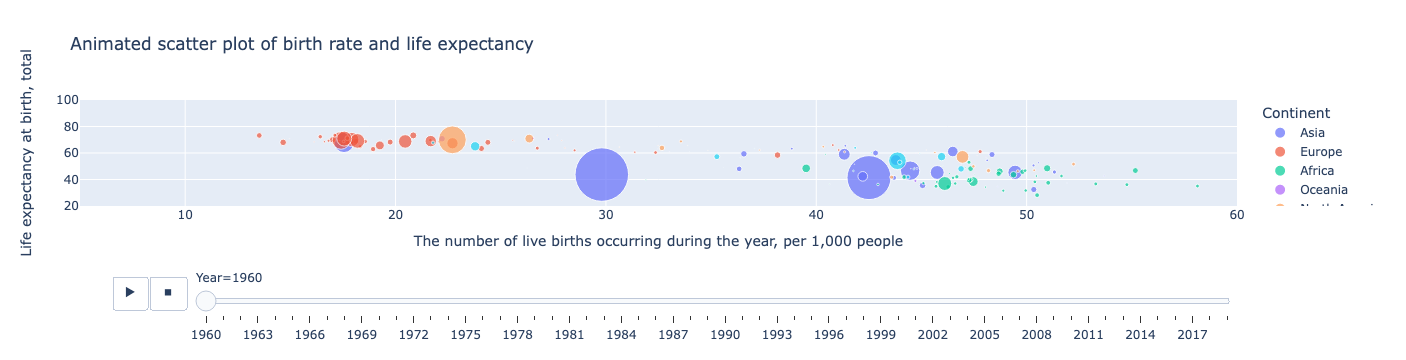

In [27]:
px.scatter(lbp_c_cleaned, 
           x="Birth_rate", 
           y="Life_expectancy", 
           animation_frame="Year",
           animation_group="Country",
           size="population", 
           color="Continent", 
           hover_name="Continent",
           size_max=55, 
           range_x=[5,60], 
           range_y=[20,100],
           labels ={"Birth_rate": 'The number of live births occurring during the year, per 1,000 people',
                    'Life_expectancy': 'Life expectancy at birth, total', }, 
           title='Animated scatter plot of birth rate and life expectancy')